# CNN Based Models

In [1]:
import os
import pathlib
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
from python_speech_features import mfcc

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from input_pipeline import _DATA_DIR_, _BINARIES_DIR_, _UNKNOWN_CLASS_, _SILENCE_CLASS_, _MODELS_DIR_
from input_pipeline import *
from metrics import *
from custom_layers import MFCC, MelSpectrogram
sns.set_context("talk")
# plt.style.use('ggplot')
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2021-08-18 03:53:58.869543: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# _SMOKE_SIZE_ = 2000
_SMOKE_SIZE_ = -1

## Import Data

In [3]:
core_kws, aux_kws, output_classes = get_kws(_DATA_DIR_)
print("Core keywords: ", core_kws)
print()
print("Auxiliary keywords: ", aux_kws)
print()
print("Output Classes: ", output_classes)

Core keywords:  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

Auxiliary keywords:  ['house', 'visual', 'forward', 'cat', 'learn', 'nine', 'five', 'wow', 'happy', 'marvin', 'six', 'zero', 'one', 'two', 'three', 'bed', 'follow', 'four', 'eight', 'bird', 'seven', 'backward', 'tree', 'dog', 'sheila']

Output Classes:  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'filler', 'silence']


In [4]:
# if the binaries for the splits are not yet generated, generate them; otherwise just load them.
if len(os.listdir(_BINARIES_DIR_)) == 0:
    #Get train, validation and test data from the splits provided in the data directory
    X_train, y_train, X_valid, y_valid, X_test, y_test = get_original_splits(_DATA_DIR_)
else:
    X_train, y_train, X_valid, y_valid, X_test, y_test = load_original_splits(_BINARIES_DIR_)

print(f"Samples in Training Set: {len(X_train)}")
print(f"Samples in Test Set: {len(X_test)}")
print(f"Samples in Validation Set: {len(X_valid)}")

Samples in Training Set: 94824
Samples in Test Set: 11005
Samples in Validation Set: 9981


In [5]:
# ADD noise samples to train, valid and test set, with the same proportion of unknown words.
unkn_i = output_classes.index(_UNKNOWN_CLASS_)
sil_i = output_classes.index(_SILENCE_CLASS_)
n_sil_train = len(y_train[y_train==0])
n_sil_valid = len(y_valid[y_valid==0])
n_sil_test = len(y_test[y_test==0])

X_train, y_train, X_valid, y_valid, X_test, y_test = add_silence_samples(X_train, 
                                                                         y_train, 
                                                                         X_valid, 
                                                                         y_valid, 
                                                                         X_test, 
                                                                         y_test,
                                                                        n_sil_train,
                                                                        n_sil_valid,
                                                                        n_sil_test)
X_train, y_train, X_valid, y_valid, X_test, y_test = get_smoke_sized(X_train, y_train, X_valid, y_valid, X_test, y_test, smoke_size=_SMOKE_SIZE_)

In [6]:
print(f"Samples in Training Set: {len(X_train)}")
print(f"Samples in Test Set: {len(X_test)}")
print(f"Samples in Validation Set: {len(X_valid)}")

Samples in Training Set: 98449
Samples in Test Set: 11424
Samples in Validation Set: 10378


In [7]:
batch_size = 64
train_dataset, train_steps, valid_dataset, valid_steps, test_dataset, test_steps = get_tf_datasets(X_train, 
                             y_train, 
                             X_valid, 
                             y_valid, 
                             X_test, 
                             y_test, 
                             batch_size=batch_size)

2021-08-18 03:54:02.460964: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-18 03:54:02.486345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-18 03:54:02.486786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7845GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2021-08-18 03:54:02.486827: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-18 03:54:02.489331: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-18 03:54:02.490256: I tensorflow/stream_executor/platf

Train steps: 1539
Validations steps: 163
Test steps: 179
Example of dataset element:
(<tf.Tensor: shape=(64, 16000), dtype=float32, numpy=
array([[ 0.00012252,  0.00012252,  0.00012252, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00201413, -0.00112705,  0.00118379, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00019453, -0.0003762 , -0.00142951, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.00307638,
         0.00773807,  0.00299675],
       [ 0.        ,  0.        ,  0.        , ...,  0.00055421,
        -0.02874318,  0.00302855],
       [ 0.        ,  0.        ,  0.        , ..., -0.00123682,
        -0.0006647 ,  0.00085423]], dtype=float32)>, <tf.Tensor: shape=(64,), dtype=int64, numpy=
array([ 7, 10,  7, 10, 10, 10, 10, 10, 10, 10,  7, 10, 10, 10, 10, 10, 10,
       10, 10, 11, 10, 10, 10,  5, 10, 10, 10, 10,  3, 10, 10,  7,  6, 10,
       10, 10,  0, 10, 10, 10, 10, 1

2021-08-18 03:54:03.732769: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-18 03:54:03.758434: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2699905000 Hz


# Baseline Models
`cnn-trad-fpool3`, `cnn-one-fstride4` from https://static.googleusercontent.com/media/research.google.com/it//pubs/archive/43969.pdf

## Model 1 (cnn-trad-fpool3)

input dimensions are: (time_dimension, frequency_dimension)

- CONV2D Layer: n_filters=64, filter_size = (20, 8), stride = (1,1);
- MaxPool2D: pool_dimension = (1, 3);
- CONV2D Layer: n_filters=64, filter_size = (10, 4), stride = (1,1);
- Dense Layer with linear activation and 32 units;
- Dense layer with ReLu activation and  128 units;
- Output Layer with n_outputs units and softmax activation.



In [8]:
def cnn_trad_fpool3(ds):
    for s, _ in ds.take(1):
        input_shape = s.shape[1:]
        print('Input shape:', input_shape)
    
    X_input = tf.keras.Input(input_shape)
    #X = MelSpectrogram(sample_rate = 16000, fft_size=512, win_size=400, hop_size=160, n_filters=40)(X_input)
    X = MFCC(sample_rate = 16000, 
             fft_size=512, 
             win_size=400, 
             hop_size=160, 
             n_filters=40, 
             n_cepstral=13,
            return_deltas=True)(X_input)
    X = layers.BatchNormalization(axis=-1)(X)
    
    X = layers.Conv2D(64, (20,8), activation='relu')(X)
    X = layers.MaxPool2D(pool_size=(1,3))(X)
    X = layers.Conv2D(64, (10,4), activation='relu')(X)
    X = layers.Flatten()(X)
    X = layers.Dense(32)(X)
    X = layers.Dense(128, activation='relu')(X)
    X = layers.Dense(len(output_classes))(X)
    
    
    model = tf.keras.Model(inputs = X_input, outputs = X, name='cnn_trad_fpool3')
    return model

model_cnn_trad_fpool3 = cnn_trad_fpool3(train_dataset)

model_cnn_trad_fpool3.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model_cnn_trad_fpool3.summary()

Input shape: (16000,)
Model: "cnn_trad_fpool3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16000)]           0         
_________________________________________________________________
mfcc (MFCC)                  (None, 98, 39, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 39, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 79, 32, 64)        10304     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 10, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 70, 7, 64)         163904    
_________________________________________________________________
flatten (Flatten)            

In [9]:
model_cnn_trad_fpool3.name

'cnn_trad_fpool3'

In [10]:
# Check if the model is saved, in that case load it. Otherwise train it.

if model_cnn_trad_fpool3.name+'.h5' in os.listdir(_MODELS_DIR_):
    #load model
    model_cnn_trad_fpool3 = load_model(_MODELS_DIR_/(model_cnn_trad_fpool3.name+'.h5'), custom_objects={"MFCC":MFCC})
    #load training data
    with open(f'models/history_{model_cnn_trad_fpool3.name}.pkl', 'rb') as inp:
        training_data = pickle.load(inp)
else:
    #Train the model
    EPOCHS = 50
    early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
    history = model_cnn_trad_fpool3.fit(
        train_dataset, 
        validation_data=valid_dataset,  
        epochs=EPOCHS,
        callbacks=[early_stopping, reduce_lr],
        steps_per_epoch=train_steps,
        validation_steps=valid_steps)
    
    #save model
    model_cnn_trad_fpool3.save(_MODELS_DIR_/(model_cnn_trad_fpool3.name+'.h5'))
    #save training data
    with open(_MODELS_DIR_/f'history_{model_cnn_trad_fpool3.name}.pkl', 'wb') as outp:
        pickle.dump(history.history, outp, pickle.HIGHEST_PROTOCOL)
    training_data = history.history

Epoch 1/50


2021-08-18 03:54:10.154664: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2021-08-18 03:54:10.243347: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-18 03:54:10.492298: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-08-18 03:54:10.522275: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-08-18 03:54:10.795185: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100


1539/1539 [==============================] - 114s 72ms/step - loss: 0.8031 - accuracy: 0.7469 - val_loss: 0.8756 - val_accuracy: 0.7438
Epoch 2/50
1539/1539 [==============================] - 111s 72ms/step - loss: 0.5011 - accuracy: 0.8375 - val_loss: 0.8253 - val_accuracy: 0.7758
Epoch 3/50
1539/1539 [==============================] - 112s 72ms/step - loss: 0.4144 - accuracy: 0.8663 - val_loss: 0.6758 - val_accuracy: 0.8227
Epoch 4/50
1539/1539 [==============================] - 106s 69ms/step - loss: 0.3614 - accuracy: 0.8851 - val_loss: 0.7425 - val_accuracy: 0.8124
Epoch 5/50
1539/1539 [==============================] - 105s 68ms/step - loss: 0.3296 - accuracy: 0.8960 - val_loss: 0.6450 - val_accuracy: 0.8362
Epoch 6/50
1539/1539 [==============================] - 110s 71ms/step - loss: 0.3085 - accuracy: 0.9015 - val_loss: 0.5985 - val_accuracy: 0.8530
Epoch 7/50
1539/1539 [==============================] - 105s 68ms/step - loss: 0.2905 - accuracy: 0.9064 - val_loss: 0.5723 - val

In [11]:
training_data

{'loss': [0.8030766248703003,
  0.5011091828346252,
  0.4144389033317566,
  0.36137816309928894,
  0.32957252860069275,
  0.3084677457809448,
  0.29054349660873413,
  0.28112974762916565,
  0.2698144018650055,
  0.26309430599212646],
 'accuracy': [0.7468526363372803,
  0.8374959230422974,
  0.8663092851638794,
  0.8851425647735596,
  0.8960363864898682,
  0.9014579057693481,
  0.9064022898674011,
  0.9104938507080078,
  0.9133873581886292,
  0.9152249693870544],
 'val_loss': [0.8755877017974854,
  0.8252946138381958,
  0.6757630705833435,
  0.7424718737602234,
  0.6449865102767944,
  0.5985456109046936,
  0.572314977645874,
  0.6044121384620667,
  0.6047214269638062,
  0.5761584043502808],
 'val_accuracy': [0.7437691688537598,
  0.7757860422134399,
  0.8226610422134399,
  0.8124041557312012,
  0.8361771702766418,
  0.8529524803161621,
  0.8546779155731201,
  0.8539110422134399,
  0.8657016754150391,
  0.8640720844268799],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 

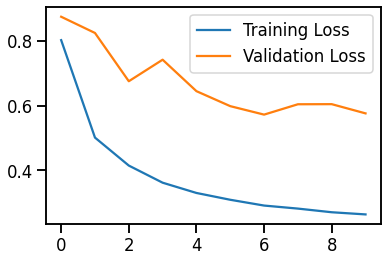

In [12]:
plt.plot(range(len(training_data['loss'])), training_data['loss'], label="Training Loss")
plt.plot(range(len(training_data['val_loss'])), training_data['val_loss'], label="Validation Loss")

plt.legend()
plt.show()

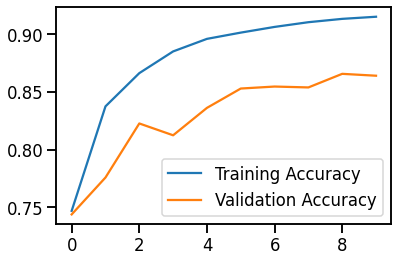

In [13]:
plt.plot(range(len(training_data['accuracy'])), training_data['accuracy'], label="Training Accuracy")
plt.plot(range(len(training_data['val_accuracy'])), training_data['val_accuracy'], label="Validation Accuracy")

plt.legend()
plt.show()

In [14]:
y_scores = model_cnn_trad_fpool3.predict(test_dataset, steps=test_steps)[:len(y_test)]
y_pred = np.array(np.argmax(y_scores, axis=1))
y_true = np.array(y_test)

Test set accuracy: 84.471%


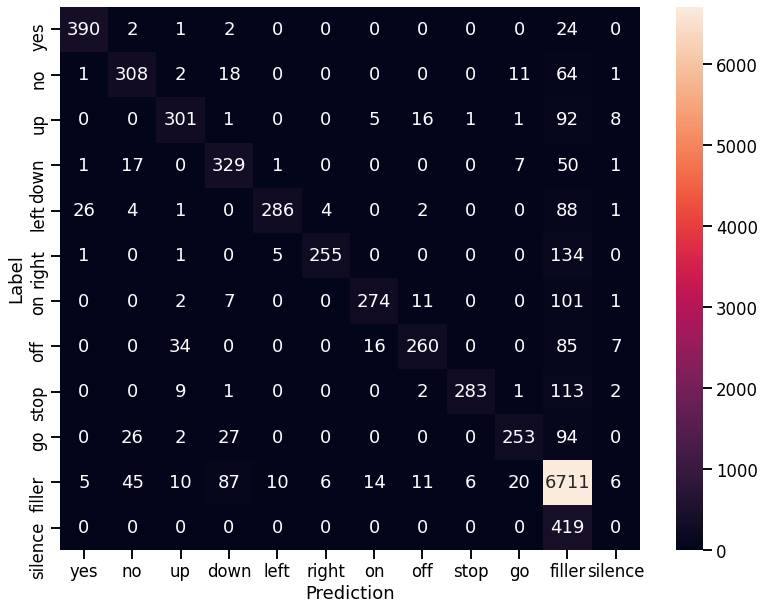

In [15]:
sns.set_context("talk")

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(13, 10))
sns.heatmap(confusion_mtx, xticklabels=output_classes, yticklabels=output_classes, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [16]:
fpr, fnr, roc_auc = get_fpr_fnr_aucs(y_test, y_scores, output_classes)

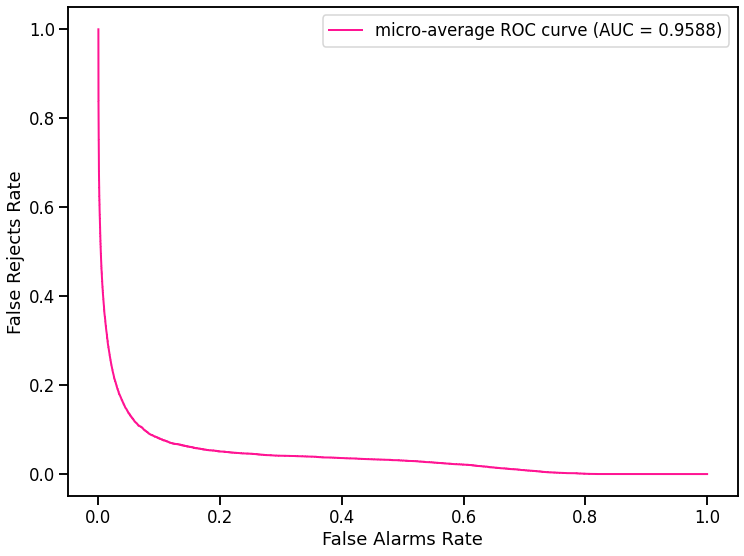

In [17]:
plt.figure(figsize=(12,9))
plt.plot(fpr["micro"], fnr["micro"],
         color='deeppink', linestyle='-', linewidth=2, label='micro-average ROC curve (AUC = {0:0.4f})'
               ''.format(roc_auc["micro"]))
plt.xlabel("False Alarms Rate")
plt.ylabel("False Rejects Rate")
plt.legend()
plt.show()

## Model 2 (cnn-one-fstride4)

input dimensions are: (time_dimension, frequency_dimension)

- CONV2D Layer: n_filters=186, filter_size = (32, 8), stride = (1,4);
- Dense Layer with linear activation and 32 units;
- Dense layer with ReLu activation and  128 units;
- Dense layer with ReLu activation and  128 units;
- Output Layer with n_outputs units and softmax activation.


In [20]:
def cnn_one_fstride4(ds):
    for s, _ in ds.take(1):
        input_shape = s.shape[1:]
        print('Input shape:', input_shape)
    
    X_input = tf.keras.Input(input_shape)
    #X = MelSpectrogram(sample_rate = 16000, fft_size=512, win_size=400, hop_size=160, n_filters=40)(X_input)
    X = MFCC(sample_rate = 16000, fft_size=512, win_size=400, hop_size=160, n_filters=40, n_cepstral=40)(X_input)
    X = layers.BatchNormalization(axis=-1)(X)
    
    X = layers.Conv2D(186, (32,8), strides=(1,4), activation='relu')(X)
    X = layers.Flatten()(X)
    X = layers.Dense(32)(X)
    X = layers.Dense(128, activation='relu')(X)
    X = layers.Dense(128, activation='relu')(X)
    X = layers.Dense(len(output_classes))(X)
    
    
    model = tf.keras.Model(inputs = X_input, outputs = X, name='cnn_one_fstride4')
    return model

model_cnn_one_fstride4 = cnn_one_fstride4(train_dataset)

model_cnn_one_fstride4.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model_cnn_one_fstride4.summary()

Input shape: (16000,)
Model: "cnn_one_fstride4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 16000)]           0         
_________________________________________________________________
mfcc_2 (MFCC)                (None, 98, 40, 1)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 98, 40, 1)         4         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 67, 9, 186)        47802     
_________________________________________________________________
flatten_2 (Flatten)          (None, 112158)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                3589088   
_________________________________________________________________
dense_8 (Dense)             

In [21]:
# Check if the model is saved, in that case load it. Otherwise train it.
if model_cnn_one_fstride4.name+'.h5' in os.listdir(_MODELS_DIR_):
    #load model
    model_cnn_one_fstride4 = load_model(_MODELS_DIR_/(model_cnn_one_fstride4.name+'.h5'), custom_objects={"MFCC":MFCC})
    #load training data
    with open(f'models/history_{model_cnn_one_fstride4.name}.pkl', 'rb') as inp:
        training_data = pickle.load(inp)
else:
    #Train the model
    EPOCHS = 50
    early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
    history = model_cnn_one_fstride4.fit(
        train_dataset, 
        validation_data=valid_dataset,  
        epochs=EPOCHS,
        callbacks=[early_stopping, reduce_lr],
        steps_per_epoch=train_steps,
        validation_steps=valid_steps)
    
    #save model
    model_cnn_one_fstride4.save(_MODELS_DIR_/(model_cnn_one_fstride4.name+'.h5'))
    #save training data
    with open(_MODELS_DIR_/f'history_{model_cnn_one_fstride4.name}.pkl', 'wb') as outp:
        pickle.dump(history.history, outp, pickle.HIGHEST_PROTOCOL)
    training_data = history.history


Epoch 1/50
1539/1539 [==============================] - 30s 19ms/step - loss: 0.6558 - accuracy: 0.7960 - val_loss: 0.6528 - val_accuracy: 0.8032
Epoch 2/50
1539/1539 [==============================] - 30s 19ms/step - loss: 0.3862 - accuracy: 0.8762 - val_loss: 0.5919 - val_accuracy: 0.8367
Epoch 3/50
1539/1539 [==============================] - 29s 19ms/step - loss: 0.3201 - accuracy: 0.8972 - val_loss: 0.6684 - val_accuracy: 0.8380
Epoch 4/50
1539/1539 [==============================] - 29s 19ms/step - loss: 0.2785 - accuracy: 0.9106 - val_loss: 0.4896 - val_accuracy: 0.8710
Epoch 5/50
1539/1539 [==============================] - 30s 19ms/step - loss: 0.2530 - accuracy: 0.9181 - val_loss: 0.5011 - val_accuracy: 0.8727
Epoch 6/50
1539/1539 [==============================] - 30s 19ms/step - loss: 0.2337 - accuracy: 0.9246 - val_loss: 0.6161 - val_accuracy: 0.8698
Epoch 7/50
1539/1539 [==============================] - 30s 19ms/step - loss: 0.2195 - accuracy: 0.9290 - val_loss: 0.6406 -

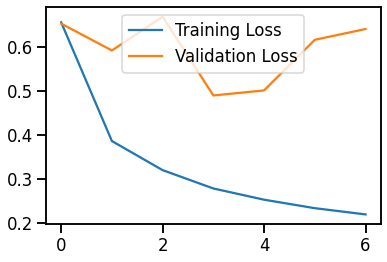

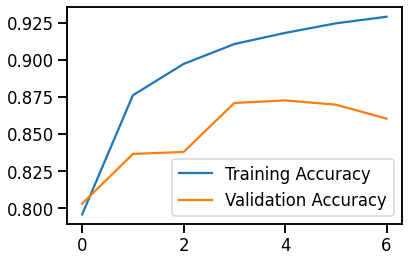

Test set accuracy: 84.226%


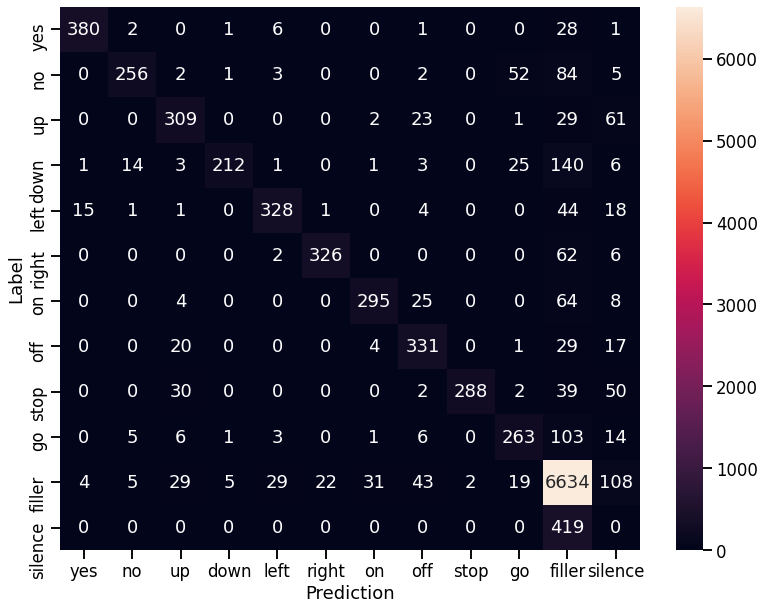

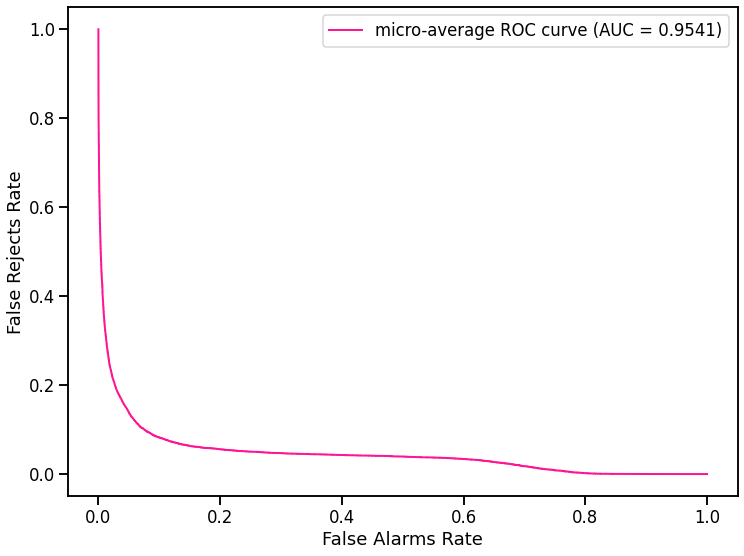

In [22]:
plt.plot(range(len(training_data['loss'])), training_data['loss'], label="Training Loss")
plt.plot(range(len(training_data['val_loss'])), training_data['val_loss'], label="Validation Loss")

plt.legend()
plt.show()

plt.plot(range(len(training_data['accuracy'])), training_data['accuracy'], label="Training Accuracy")
plt.plot(range(len(training_data['val_accuracy'])), training_data['val_accuracy'], label="Validation Accuracy")

plt.legend()
plt.show()

y_scores = model_cnn_one_fstride4.predict(test_dataset, steps=test_steps)[:len(y_test)]
y_pred = np.array(np.argmax(y_scores, axis=1))
y_true = np.array(y_test)

sns.set_context("talk")

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(13, 10))
sns.heatmap(confusion_mtx, xticklabels=output_classes, yticklabels=output_classes, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

fpr, fnr, roc_auc = get_fpr_fnr_aucs(y_test, y_scores, output_classes)

plt.figure(figsize=(12,9))
plt.plot(fpr["micro"], fnr["micro"],
         color='deeppink', linestyle='-', linewidth=2, label='micro-average ROC curve (AUC = {0:0.4f})'
               ''.format(roc_auc["micro"]))
plt.xlabel("False Alarms Rate")
plt.ylabel("False Rejects Rate")
plt.legend()
plt.show()

## ResNet

In [23]:
from tensorflow.keras.initializers import glorot_uniform

In [24]:
def identity_block(X_input, f, filters, stage, block):

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters

    # First component of main path
    X = layers.Conv2D(filters = F1, kernel_size = (1, 1), strides = (1, 1), 
               padding = 'valid', name = conv_name_base + '1th', 
               kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = layers.BatchNormalization(axis = -1, name = bn_name_base + '1th')(X)
    X = layers.Activation('relu')(X)
    
    # Second component of main path
    X = layers.Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), 
               padding = 'same', name = conv_name_base + '2nd', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis =-1, name = bn_name_base + '2nd')(X)
    X = layers.Activation('relu')(X)

    # Third component of main path
    X = layers.Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), 
               padding = 'valid', name = conv_name_base + '3rd', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis = -1, name = bn_name_base + '3rd')(X)
    print(X_input.shape)
    print(X.shape)
    X = layers.Add()([X_input, X])
    X = layers.Activation('relu')(X)    
    return X

In [25]:
def convolutional_block(X_input, f, filters, stage, block, s = 2):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters

    ##### MAIN PATH ##### 
    # First component of main path
    X = layers.Conv2D(F1, (1, 1), strides = (s, s), padding = 'valid', name = conv_name_base + '1st', 
               kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = layers.BatchNormalization(axis = -1, name = bn_name_base + '1st')(X)
    X = layers.Activation('relu')(X)
    
    # Second component of main path
    X = layers.Conv2D(F2, (f, f), strides = (1, 1), padding = 'same', name = conv_name_base + '2nd', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis = -1, name = bn_name_base + '2nd')(X)
    X = layers.Activation('relu')(X)

    # Third component of main path 
    X = layers.Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid', name = conv_name_base + '3rd', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis = -1, name = bn_name_base + '3rd')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = layers.Conv2D(F3, (1, 1), strides = (s, s), padding = 'valid', name = conv_name_base + '1', 
               kernel_initializer = glorot_uniform(seed=0))(X_input)
    X_shortcut = layers.BatchNormalization(axis = -1, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = layers.Add()([X_shortcut, X])
    X = layers.Activation('relu')(X)

    
    return X

In [26]:
def kws_res_net(ds):
    for s, _ in ds.take(1):
        input_shape = s.shape[1:]
        print('Input shape:', input_shape)
    
    X_input0 = tf.keras.Input(input_shape)
    #X = MelSpectrogram(sample_rate = 16000, fft_size=512, win_size=400, hop_size=160, n_filters=40)(X_input)
    X_input = MFCC(sample_rate = 16000, fft_size=512, win_size=400, hop_size=160, n_filters=40, n_cepstral=40)(X_input0)
    X = layers.BatchNormalization(axis=-1)(X_input)
    # Define the input as a tensor with shape input_shape (1 line)
    # Zero-padding 1x1 (1 line)
#     X = layers.ZeroPadding2D((1, 1))(X_input)
    
    # Stage 1 (4 lines)
    X = layers.Conv2D(64, (20,8), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis =-1, name = 'bn_conv1')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((1, 3))(X)

    # Stage 2 (3 lines)
    X = convolutional_block(X, f = 3, filters = [64, 64, 64], stage = 2, block='a', s = 2)
    X = identity_block(X, 3, [64, 64, 64], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 64], stage=2, block='c')

#     # Stage 3 (4 lines)
#     X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
#     X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
#     X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
#     X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

#     # Stage 4 (6 lines)
#     X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
#     X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
#     X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
#     X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
#     X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
#     X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (3 lines)
#     X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
#     X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
#     X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (1 line). Use "X = AveragePooling2D(...)(X)"
    X = tf.keras.layers.AveragePooling2D(name='avg_pool')(X)

    # Output layer
    X = layers.Flatten()(X)
    X = layers.Dense(len(output_classes), name='fc', kernel_initializer = glorot_uniform(seed=0))(X)
    
    ### END CODE HERE ###
    
    # Create model
    model = tf.keras.Model(inputs = X_input0, outputs = X, name='ResNetKWS')

    return model

In [27]:
model_res_net = kws_res_net(train_dataset)

model_res_net.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model_res_net.summary()

Input shape: (16000,)
(None, 40, 6, 64)
(None, 40, 6, 64)
(None, 40, 6, 64)
(None, 40, 6, 64)
Model: "ResNetKWS"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 16000)]      0                                            
__________________________________________________________________________________________________
mfcc_3 (MFCC)                   (None, 98, 40, 1)    0           input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 98, 40, 1)    4           mfcc_3[0][0]                     
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 79, 33, 64)   10304       batch_normalization_3[0][0]   

In [28]:
# Check if the model is saved, in that case load it. Otherwise train it.
if model_res_net.name+'.h5' in os.listdir(_MODELS_DIR_):
    #load model
    model_res_net = load_model(_MODELS_DIR_/(model_res_net.name+'.h5'), custom_objects={"MFCC":MFCC})
    #load training data
    with open(f'models/history_{model_res_net.name}.pkl', 'rb') as inp:
        training_data = pickle.load(inp)
else:
    #Train the model
    EPOCHS = 50
    early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
    history = model_res_net.fit(
        train_dataset, 
        validation_data=valid_dataset,  
        epochs=EPOCHS,
        callbacks=[early_stopping, reduce_lr],
        steps_per_epoch=train_steps,
        validation_steps=valid_steps)
    
    #save model
    model_res_net.save(_MODELS_DIR_/(model_res_net.name+'.h5'))
    #save training data
    with open(_MODELS_DIR_/f'history_{model_res_net.name}.pkl', 'wb') as outp:
        pickle.dump(history.history, outp, pickle.HIGHEST_PROTOCOL)
    training_data = history.history

Epoch 1/50
1539/1539 [==============================] - 58s 36ms/step - loss: 0.5720 - accuracy: 0.8263 - val_loss: 0.5732 - val_accuracy: 0.8306
Epoch 2/50
1539/1539 [==============================] - 58s 38ms/step - loss: 0.2817 - accuracy: 0.9115 - val_loss: 0.6956 - val_accuracy: 0.8320
Epoch 3/50
1539/1539 [==============================] - 58s 37ms/step - loss: 0.2267 - accuracy: 0.9292 - val_loss: 0.5010 - val_accuracy: 0.8839
Epoch 4/50
1539/1539 [==============================] - 58s 38ms/step - loss: 0.1954 - accuracy: 0.9384 - val_loss: 0.4916 - val_accuracy: 0.8896
Epoch 5/50
1539/1539 [==============================] - 57s 37ms/step - loss: 0.1744 - accuracy: 0.9453 - val_loss: 0.4699 - val_accuracy: 0.8915
Epoch 6/50
1539/1539 [==============================] - 57s 37ms/step - loss: 0.1593 - accuracy: 0.9500 - val_loss: 0.5353 - val_accuracy: 0.8953
Epoch 7/50
1539/1539 [==============================] - 57s 37ms/step - loss: 0.1465 - accuracy: 0.9534 - val_loss: 0.4993 -

/home/rmazzier/Desktop/HDA/tf_venv/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


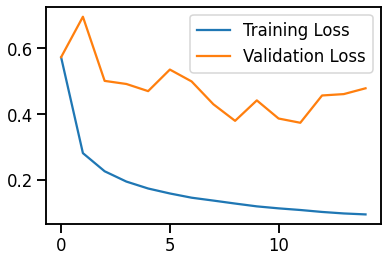

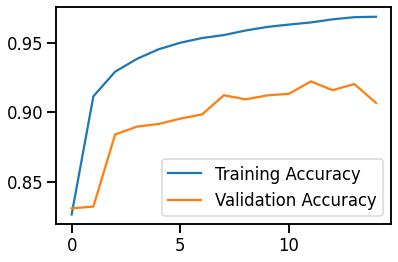

Test set accuracy: 89.251%


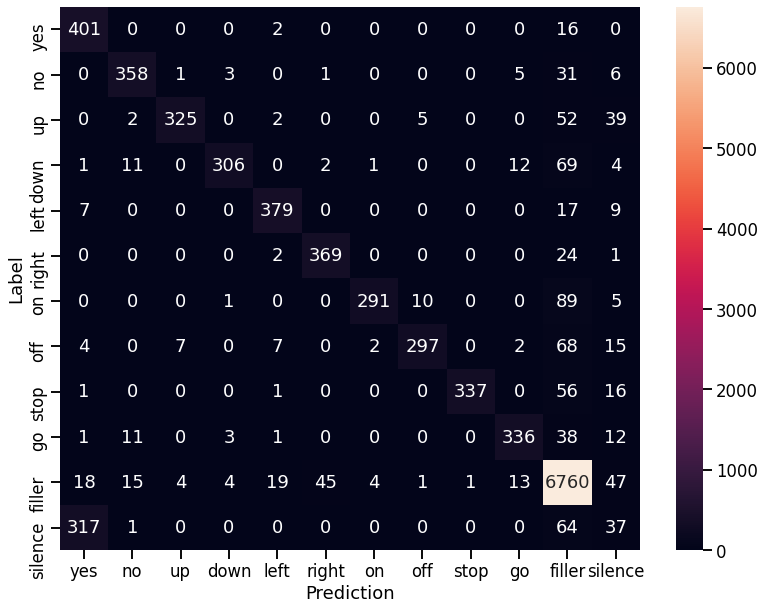

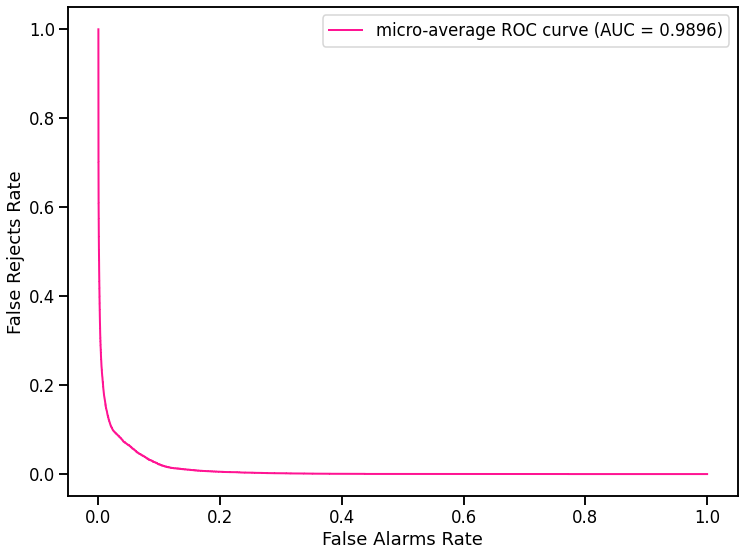

In [29]:
plt.plot(range(len(training_data['loss'])), training_data['loss'], label="Training Loss")
plt.plot(range(len(training_data['val_loss'])), training_data['val_loss'], label="Validation Loss")

plt.legend()
plt.show()

plt.plot(range(len(training_data['accuracy'])), training_data['accuracy'], label="Training Accuracy")
plt.plot(range(len(training_data['val_accuracy'])), training_data['val_accuracy'], label="Validation Accuracy")

plt.legend()
plt.show()

y_scores = model_res_net.predict(test_dataset, steps=test_steps)[:len(y_test)]
y_pred = np.array(np.argmax(y_scores, axis=1))
y_true = np.array(y_test)

sns.set_context("talk")

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(13, 10))
sns.heatmap(confusion_mtx, xticklabels=output_classes, yticklabels=output_classes, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

fpr, fnr, roc_auc = get_fpr_fnr_aucs(y_test, y_scores, output_classes)

plt.figure(figsize=(12,9))
plt.plot(fpr["micro"], fnr["micro"],
         color='deeppink', linestyle='-', linewidth=2, label='micro-average ROC curve (AUC = {0:0.4f})'
               ''.format(roc_auc["micro"]))
plt.xlabel("False Alarms Rate")
plt.ylabel("False Rejects Rate")
plt.legend()
plt.show()